In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

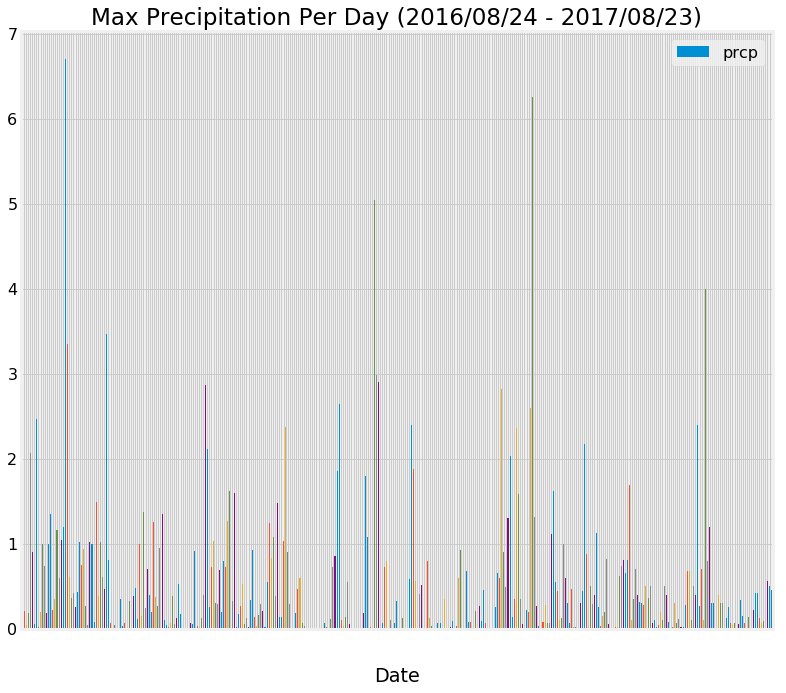

In [63]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)

columns_tbl1 = inspector.get_columns('measurement') #id(int), station(txt), date(txt), prcp(flt), tobs(flt)
columns_tbl2 = inspector.get_columns('station') #id(int), station(txt), name(txt), latitude(flt), longitude(flt), elevation(flt)

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = str(int(last_date[0:4]) - 1) + last_date[4:8] + str(int(last_date[8:10]) + 1)

# Perform a query to retrieve the data and precipitation scores
prcp_last_12_months = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc())\
    .filter(func.strftime("%Y-%m-%d", Measurement.date) >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_last_12_months).set_index("date")

# Sort the dataframe by date
df2 = df.copy().fillna(value=0)
df3 = df2.sort_values("date", ascending=True).iloc[0:]
high = df3.groupby(["date"]).max()

# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams.update({'font.size': 16})
plt.rcParams["text.color"] = "black"
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['xtick.color'] = "white"

high["prcp"].plot(kind="bar", figsize=(12,11), use_index=False, grid=True, legend=True)
plt.title("Max Precipitation Per Day (2016/08/23 - 2017/08/24)")
plt.xlabel("Date")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df3.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).all()
station_count

[(9)]

In [50]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
top_station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == station_activity[0][0]).all()

top_station_stats

[(54.0, 85.0, 71.66378066378067)]

<Figure size 432x288 with 0 Axes>

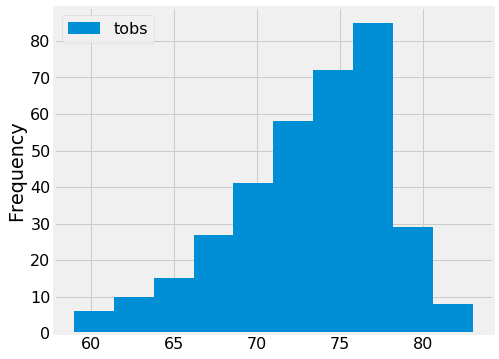

In [107]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_year = session.query(Measurement.station, Measurement.date, Measurement.tobs, Measurement.prcp)\
    .order_by(Measurement.date.asc())\
    .filter(func.strftime("%Y-%m-%d", Measurement.date) >= one_year_ago)\
    .filter(Measurement.station == station_activity[0][0]).all()

top_year_df = pd.DataFrame(top_year)#.set_index("date")
top_tobs_df = top_year_df[["tobs"]]

#top_year_df.head(50)
plt.figure()
plt.rcParams['xtick.color'] = "black"
top_tobs_df.plot(kind="hist", figsize=(7,6))

In [108]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


In [117]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-04-16', '2016-04-20')[0][0],\
      calc_temps('2016-04-16', '2016-04-20')[0][1],\
      calc_temps('2016-04-16', '2016-04-20')[0][2])

66.0 72.3225806451613 80.0


Text(0.5, 1.0, 'Trip Avg Temp')

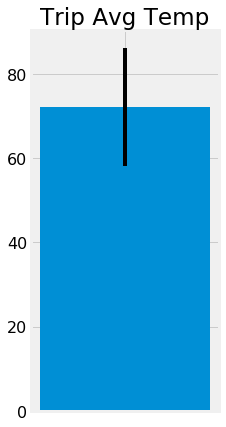

In [167]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,7))
plt.bar(yerr=14, height=72, x="")
plt.title("Trip Avg Temp")

In [197]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_prcp(start_date, end_date):

    station_prcp = session.query(Measurement.station, func.sum(Measurement.prcp))\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())\
                       .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    list1 = []
    for i in station_prcp:
        station = i[0]
        print(session.query(Station.station, Station.name, Station.latitude,\
                         Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                         filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                         filter(Measurement.station == station).\
                         filter(Station.station == station).all())
        
     

calc_prcp('2016-04-16', '2016-04-20')

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 6.1000000000000005)]
[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.45)]
[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.6300000000000001)]
[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.55)]
[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.49)]
[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.32)]
[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]
